In [51]:
import sys
sys.path.append("..")

import torch
import nip
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

import lib.datasets.keys as keys
from PIL import Image
from pathlib import Path

from lib.models.vint_base.full_model import ViNTModel

from tqdm.auto import tqdm
from typing import Callable, Any
from pathlib import Path
from lib.datasets.image_loaders import LOADER_TURBOJPEG, AbstractImageLoader, resolve_image_loader
from lib.utils.math import to_relative_frame 

from lib.utils.action import position_deltas_to_waypoints

from notebooks.camera_tools.camera_utils import DEFAULT_CAMERA_PARAMS, project_points, CameraParameters
from notebooks.camera_tools.math_utils import to_relative_frame
from functools import partial

DEFAULT_MEAN_HIGHT = 129.4333333
DEFAULT_CAMERA_PARAMS.camera_height = DEFAULT_MEAN_HIGHT

_IMAGE_WIDTH = 960
_IMAGE_HEIGHT = 600

coeffs = np.array((120 / _IMAGE_WIDTH, 160 / _IMAGE_HEIGHT))


In [63]:
class FullTrajectoryIterator:

    _TRAJECTORY_FILE = "trajectory.npy"
    _IMAGES_DIR = "rgb_images"
    _SEGMENTATION_DIR = "segmentation"
    _IMAGE_EXT = "jpg"

    def __init__(self,
                 trajectory_root: str | Path,
                 context_length: int = 5,
                 action_length: int = 8,
                 image_loader: str | AbstractImageLoader = LOADER_TURBOJPEG,
                 image_processor: Callable[[torch.Tensor], torch.Tensor] | None = None,
                 pickle = None,
                 frames_path = None) -> None:
        self._image_loader = resolve_image_loader(image_loader)
        self._image_processor = image_processor
        self._trajectory_root = Path(trajectory_root)
        self._context_length = context_length
        self._action_length = action_length
        
        if pickle is None:
            self._images = sorted((self._trajectory_root / FullTrajectoryIterator._IMAGES_DIR).glob(f"*.{FullTrajectoryIterator._IMAGE_EXT}"))
            self._masks = [Path(str(image).replace("rgb_images", "segmentation")) for image in self._images]
        else:
            with open(str(self._trajectory_root) / pickle, "rb") as f:
                all_samples = pickle.load(f)
            self._images, self._masks = [], []
            for sample in all_samples:
                self._images.append(frames_path / sample["observation"])
                self._masks.append(frames_path / Path(str(sample["observation"]).replace("rgb_images", "segmentation")))

        
        trajectory_file = self._trajectory_root / FullTrajectoryIterator._TRAJECTORY_FILE
        if trajectory_file.is_file():
            self._trajectory = np.load(str(self._trajectory_root / FullTrajectoryIterator._TRAJECTORY_FILE))
            assert self._trajectory.shape[0] == len(self._images), f"Number of RGB frames must be equal to the trajectory length"
        else:
            self._trajectory = None

        self._max_observation_idx = len(self._images) - action_length - 1
        self._max_goal_idx = len(self._images) - 1

    @property
    def max_observation_idx(self) -> int:
        return self._max_observation_idx
    
    @property
    def max_goal_idx(self) -> int:
        return self._max_goal_idx
    
    def get_data(self, observation_idx: int, goal_idx: int) -> dict[str, Any]:
        assert goal_idx > observation_idx, f"Goal idx must be > than observation idx, got {goal_idx} and {observation_idx}"
        assert observation_idx <= self._max_observation_idx
        assert goal_idx <= self._max_goal_idx

        context_idxs = tuple((observation_idx - 1 - i if observation_idx - 1 - i > 0 else 0 for i in range(self._context_length)))[::-1]
        # print(context_idxs)

        context = [self._load_and_transform_image(self._images[i]) for i in context_idxs]
        context = torch.stack(context, dim=0)
        observation = self._load_and_transform_image(self._images[observation_idx])
        goal = self._load_and_transform_image(self._images[goal_idx])
        mask = self._load_and_transform_mask(self._masks[observation_idx])

        context_np = [self._load_image_numpy(self._images[i]) for i in context_idxs]
        context_np = np.stack(context_np, axis=0)
        observation_np = self._load_image_numpy(self._images[observation_idx])
        goal_np = self._load_image_numpy(self._images[goal_idx])
        

        if self._trajectory is not None:
            action = self._trajectory[observation_idx:observation_idx + self._action_length + 1, :]
            action = to_relative_frame(action)[1:, :].astype(np.float32)
            if goal_idx - observation_idx < self._action_length:
                action[goal_idx - observation_idx:, :] = action[goal_idx - observation_idx]

            action = torch.from_numpy(action)
        else:
            action = None

        goal_distance = torch.as_tensor(goal_idx - observation_idx, dtype=torch.int64)

        return {
            keys.KEY_CONTEXT: context,
            keys.KEY_OBSERVATION: observation,
            keys.KEY_GOAL: goal,
            keys.KEY_ACTION: action,
            keys.KEY_GOAL_DISTANCE: goal_distance,
            keys.KEY_CONTEXT_NP: context_np,
            keys.KEY_OBSERVATION_NP: observation_np,
            keys.KEY_GOAL_NP: goal_np,
            keys.KEY_SEGMENTATION_MASK: mask,
            keys.KEY_OBSERVATION_PATH: self._images[observation_idx], 
            keys.KEY_SEGMENTATION_PATH: self._masks[observation_idx]
        }
    
    def load_separate_sample(self, observation_path: Path, goal_path: Path) -> torch.Tensor:
        observation = self._load_and_transform_image(observation_path)
        goal = self._load_and_transform_image(goal_path)
        context = observation.repeat(self._context_length, 1, 1, 1)

        observation_np = self._load_image_numpy(observation_path)
        goal_np = self._load_image_numpy(goal_path)

        return {
            keys.KEY_CONTEXT: context,
            keys.KEY_OBSERVATION: observation,
            keys.KEY_GOAL: goal,
            keys.KEY_OBSERVATION_NP: observation_np,
            keys.KEY_GOAL_NP: goal_np
        }
        
    def _load_and_transform_image(self, image_path: Path) -> torch.Tensor:
        image = self._image_loader(image_path)
        image = self._image_processor(image=image)["image"]
        return image
    
    def _load_image_numpy(self, image_path: Path) -> np.ndarray:
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def _load_and_transform_mask(self, mask_path: str) -> torch.Tensor:
        # mask_path = self._parsed_datasets_path / Path(mask_path)
        image = Image.open(mask_path).convert("L")
        mask = np.array(image)
        mask = self._image_processor(image=mask)["image"]
        # mask = torch.tensor(mask)
        return mask



In [5]:
def plot_joint_data(sample: dict[str, np.ndarray | torch.Tensor], title: str, pred_traj: torch.Tensor | None = None, points = None, lim=5):
    observation = sample["observation_np"]
    print(f'{observation.shape=}')
    goal = sample["goal_np"]

    fig, ax = plt.subplot_mosaic(
            [["obs", "goal", "traj"]],
            figsize=(14, 10),
            constrained_layout=True,
        )

    ax1 = ax["obs"]
    ax2 = ax["goal"]
    ax3 = ax["traj"]

    ax3.set_aspect('equal', 'box')
    ax3.invert_xaxis()
    ax3.set_xlim(-lim, lim)
    ax3.set_ylim(-lim, lim)
    if keys.KEY_ACTION in sample:
        traj = sample[keys.KEY_ACTION]
        if traj is not None:
            traj = traj.clone().detach().cpu().numpy()
            ax3.scatter(x=traj[:,1], y=traj[:, 0], label="GT")
    if pred_traj is not None:
        pred_traj = pred_traj.clone().detach().cpu().numpy()
        ax3.scatter(x=pred_traj[:,1], y=pred_traj[:, 0], label="Pred")
    ax3.set_xlabel("Y")
    ax3.set_ylabel("X")


    if points is not None:
        for coord in points:
            cv2.circle(observation, coord, 10, (0,0,255), 3)
    
    ax1.imshow(observation)
    ax1.axis("off")
    ax2.imshow(goal)
    ax2.axis("off")

    if pred_traj is not None:
        ax3.legend()

    plt.title(title)
    display(plt.gcf())
    plt.show()

In [6]:
def load_model(model_dir: str | Path) -> tuple[ViNTModel, Callable[[np.ndarray], torch.Tensor]]:
    model_dir = Path(model_dir)
    model = None
    image_processor = None
    for obj in nip.load(model_dir / "config_inference.yaml", always_iter=True):
        model = obj["model"]
        image_processor = obj["image_processor"]
        break
    weights = torch.load(str(model_dir / "weights.pth.tar"), map_location="cpu")
    model.load_state_dict(weights)
    return model, image_processor


def predict_diffusion(model: ViNTModel, 
                      context: torch.Tensor, 
                      observation: torch.Tensor, 
                      goal: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    
    with torch.no_grad():
        model_output = model(context=context,
                             observation=observation,
                             goal=goal)
        preidcted_deltas = model_output["position_deltas"]
        predicted_distance = model_output["distance"]
        predicted_waypoints = position_deltas_to_waypoints(preidcted_deltas,
                                                           delta_limits=model.heads["position_deltas"].output_limits.clone().to(context.device))
        return predicted_waypoints, predicted_distance

In [ ]:
model, image_processor = load_model("/home/ruslan_babakyan/projects/multinav/test_model/3")
model.to("cuda")
_ = model.eval()
# beluga_dataset_path = Path('/mnt/vol0/datasets/joint_navigation_dataset/parsed_trajectories/beluga/rosbag2_navigation_for_graph_21_feb_2024/')
full_traj = FullTrajectoryIterator(trajectory_root='/mnt/vol0/datasets/joint_navigation_dataset/parsed_trajectories/beluga/rosbag2_navigation_for_graph_21_feb_2024/',
                                   image_processor=image_processor,
                                   action_length=8)

In [64]:
full_traj = FullTrajectoryIterator(trajectory_root='/mnt/vol0/datasets/joint_navigation_dataset/parsed_trajectories/beluga/rosbag2_navigation_for_graph_21_feb_2024/',
                                   image_processor=image_processor,
                                   action_length=8)

In [48]:
start_frame = 250
choices = list(range(full_traj.max_observation_idx))[start_frame:]
step = 8

In [47]:
def calculate_mse(ground_truth, predicted):
    ground_truth = ground_truth[:,0:2]
    predicted = predicted.squeeze().cpu()
    mse = torch.nn.functional.mse_loss(predicted, ground_truth)
    return mse

In [59]:
import json

In [ ]:
mse = []
for i in tqdm(choices):
    sample = full_traj.get_data(i, i+step)

    action, distance = predict_diffusion(model,
                            sample[keys.KEY_CONTEXT].unsqueeze(0).to("cuda"),
                            sample[keys.KEY_OBSERVATION].unsqueeze(0).to("cuda"),
                            sample[keys.KEY_GOAL].unsqueeze(0).to("cuda"))
    mse_value = calculate_mse(sample[keys.KEY_ACTION], action)
    mse.append(mse_value.item())
print(mse)
file_name = 'new_nomad.json'
with open(file_name, 'w') as json_file:
    json.dump(mse, json_file, indent=4)

In [2]:
import json

import numpy as np

import matplotlib.pyplot as plt

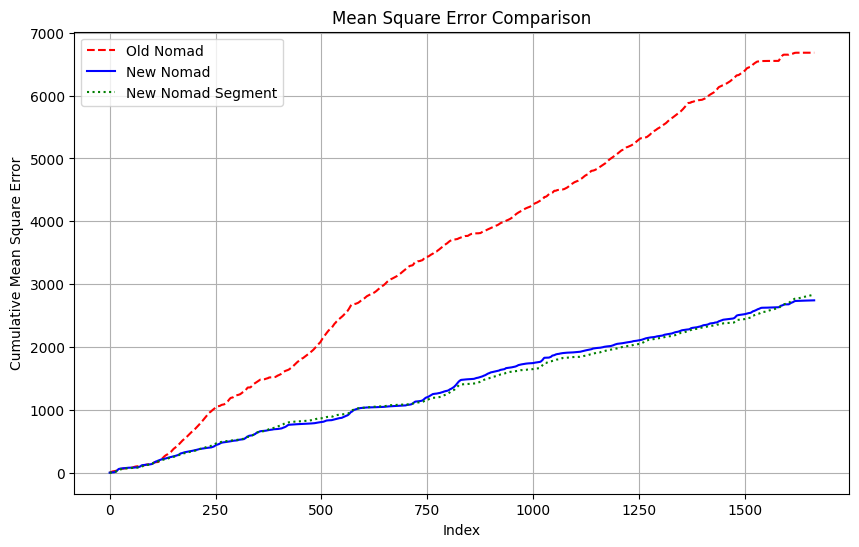

In [9]:

with open('old_nomad.json', 'r') as json_file:
    old_nomad = json.load(json_file)

with open('new_nomad.json', 'r') as json_file:
    new_nomad = json.load(json_file)

with open('new_nomad_seg.json', 'r') as json_file:
    new_nomad_seg = json.load(json_file)


new_nomad_seg = np.cumsum(np.array(new_nomad_seg))
old_nomad = np.cumsum(np.array(old_nomad))
new_nomad = np.cumsum(np.array(new_nomad))


plt.figure(figsize=(10, 6))
plt.plot(old_nomad, label='Old Nomad', color='red', linestyle='--')
plt.plot(new_nomad, label='New Nomad', color='blue', linestyle='-')
plt.plot(new_nomad_seg, label='New Nomad Segment', color='green', linestyle=':')


plt.title('Mean Square Error Comparison')
plt.xlabel('Index')
plt.ylabel('Cumulative Mean Square Error')

plt.legend()

plt.grid(True)

plt.show()
